# Introduction

Nous avonc accès, pour ce projet, au dataset 'Breast Cancer Winsconsin' qui contient des données sur les victimes de cancer du sein.

Afin de déterminer si le perceptron est un modèle efficace sur ce type de problématique, c'est à dire les données de santé et leur prédiction; nous allons procéder de la manière suivante : 

* Nettoyage des données
* Analyse des données nettoyées
* Réduction des dimensions
* Modélisation des données via le Perceptron que nous avons développé
* Conclusion sur l'efficacité du modèle & proposition de solutions

# Nettoyage des données

On commence par importer les librairies nécessaires

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import numpy as np

On importe le dataset, lance sa lecture et affiche les premières lignes afin d'avoir un aperçu

In [32]:
# Chargement du fichier
file_path = 'bcw_data.csv'

# Lecture des données
data = pd.read_csv(file_path)

# Aperçu des premières lignes du dataset
print(data.head())
print(data.info())
print(data.describe())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

On remarque qu'il y a des colonnes inutiles, notamment la colonne id qui ne sera pas utile dans notre analyse ainsi que la colonne unamed qui est complètement vide. On va donc les supprimer

In [33]:
# Suppression des colonnes inutiles
data_cleaned = data.drop(columns=["Unnamed: 32", "id"])

Suite à cette suppression nous vérifions s'il y a des valeurs manquantes et les supprimer si c'est le cas

In [34]:
# Vérification des valeurs manquantes
if data_cleaned.isnull().sum().sum() > 0:
    print("Attention : Il y a des valeurs manquantes dans les données.")
    data_cleaned = data_cleaned.dropna()

Nous allons ensuite vérifier qu'il n'y ait pas de doublons dans le dataset et les supprimer si c'est le cas

In [35]:
# Vérification des doublons
if data_cleaned.duplicated().sum() > 0:
    print("Attention : Il y a des doublons dans les données.")
    data_cleaned = data_cleaned.drop_duplicates()

# Analyse des données nettoyées

Nous allons commencer par encoder la variable cible

In [36]:
# Encodage de la variable cible
data_cleaned['diagnosis'] = data_cleaned['diagnosis'].map({'B': 0, 'M': 1})

Ensuite nous allons observer la répartition des deux diagnostics

In [37]:
# Aperçu de la répartition des diagnostics
diagnosis_distribution = data_cleaned["diagnosis"].value_counts()

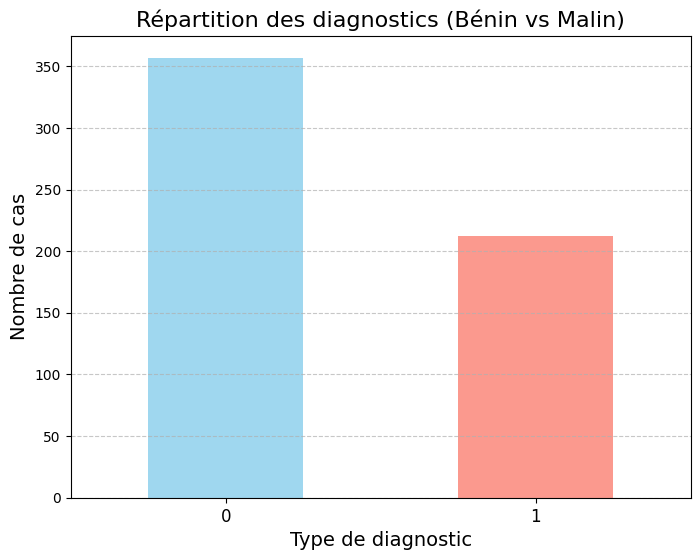

In [38]:
# Visualisation de la répartition des diagnostics
plt.figure(figsize=(8, 6))
diagnosis_distribution.plot(kind='bar', color=['skyblue', 'salmon'], alpha=0.8)
plt.title('Répartition des diagnostics (Bénin vs Malin)', fontsize=16)
plt.xlabel('Type de diagnostic', fontsize=14)
plt.ylabel('Nombre de cas', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ici on peut voir que la plupart des patients ont un diagnostic bénin qui représente 350 patients environ contre environ 200 pour le diagnostic malin

In [39]:
# Calcul des corrélations entre les variables numériques
correlation_matrix = data_cleaned.drop(columns=["diagnosis"]).corr()

Maintenant nous allons observer les corrélations entre les différentes variables numériques

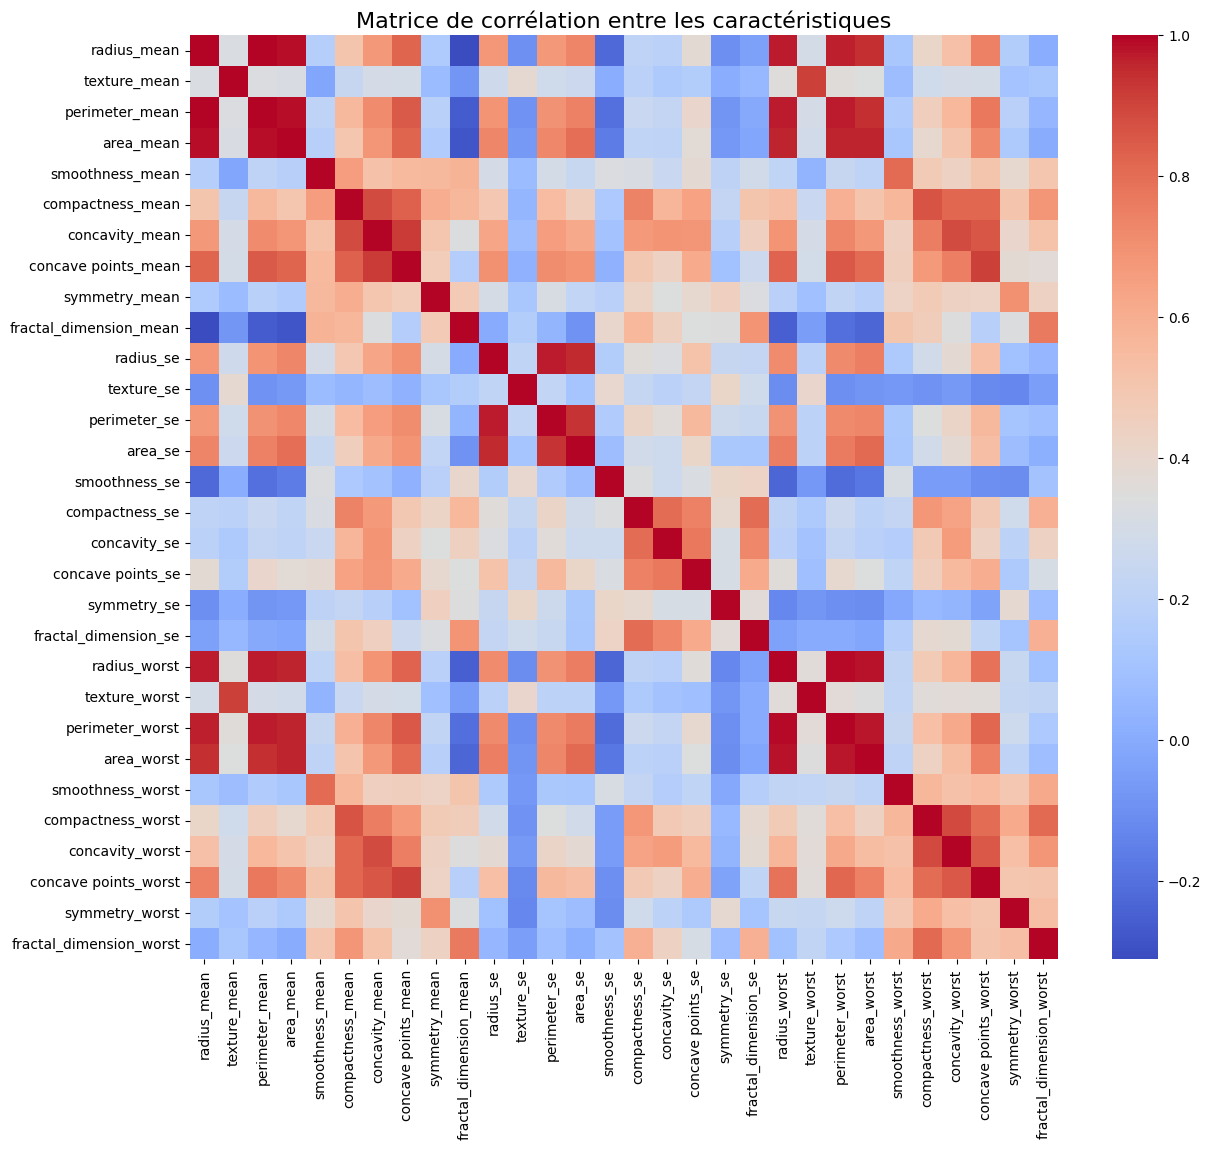

In [40]:
# Visualisation de la matrice de corrélation
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
plt.title('Matrice de corrélation entre les caractéristiques', fontsize=16)
plt.show()

On remarque immédiatement qu'il y a plusieurs variables avec une très fortes corrélation tels que radius_worst & radius_mean, perimeter_mean & radius_mean etc

### Analyse univariée

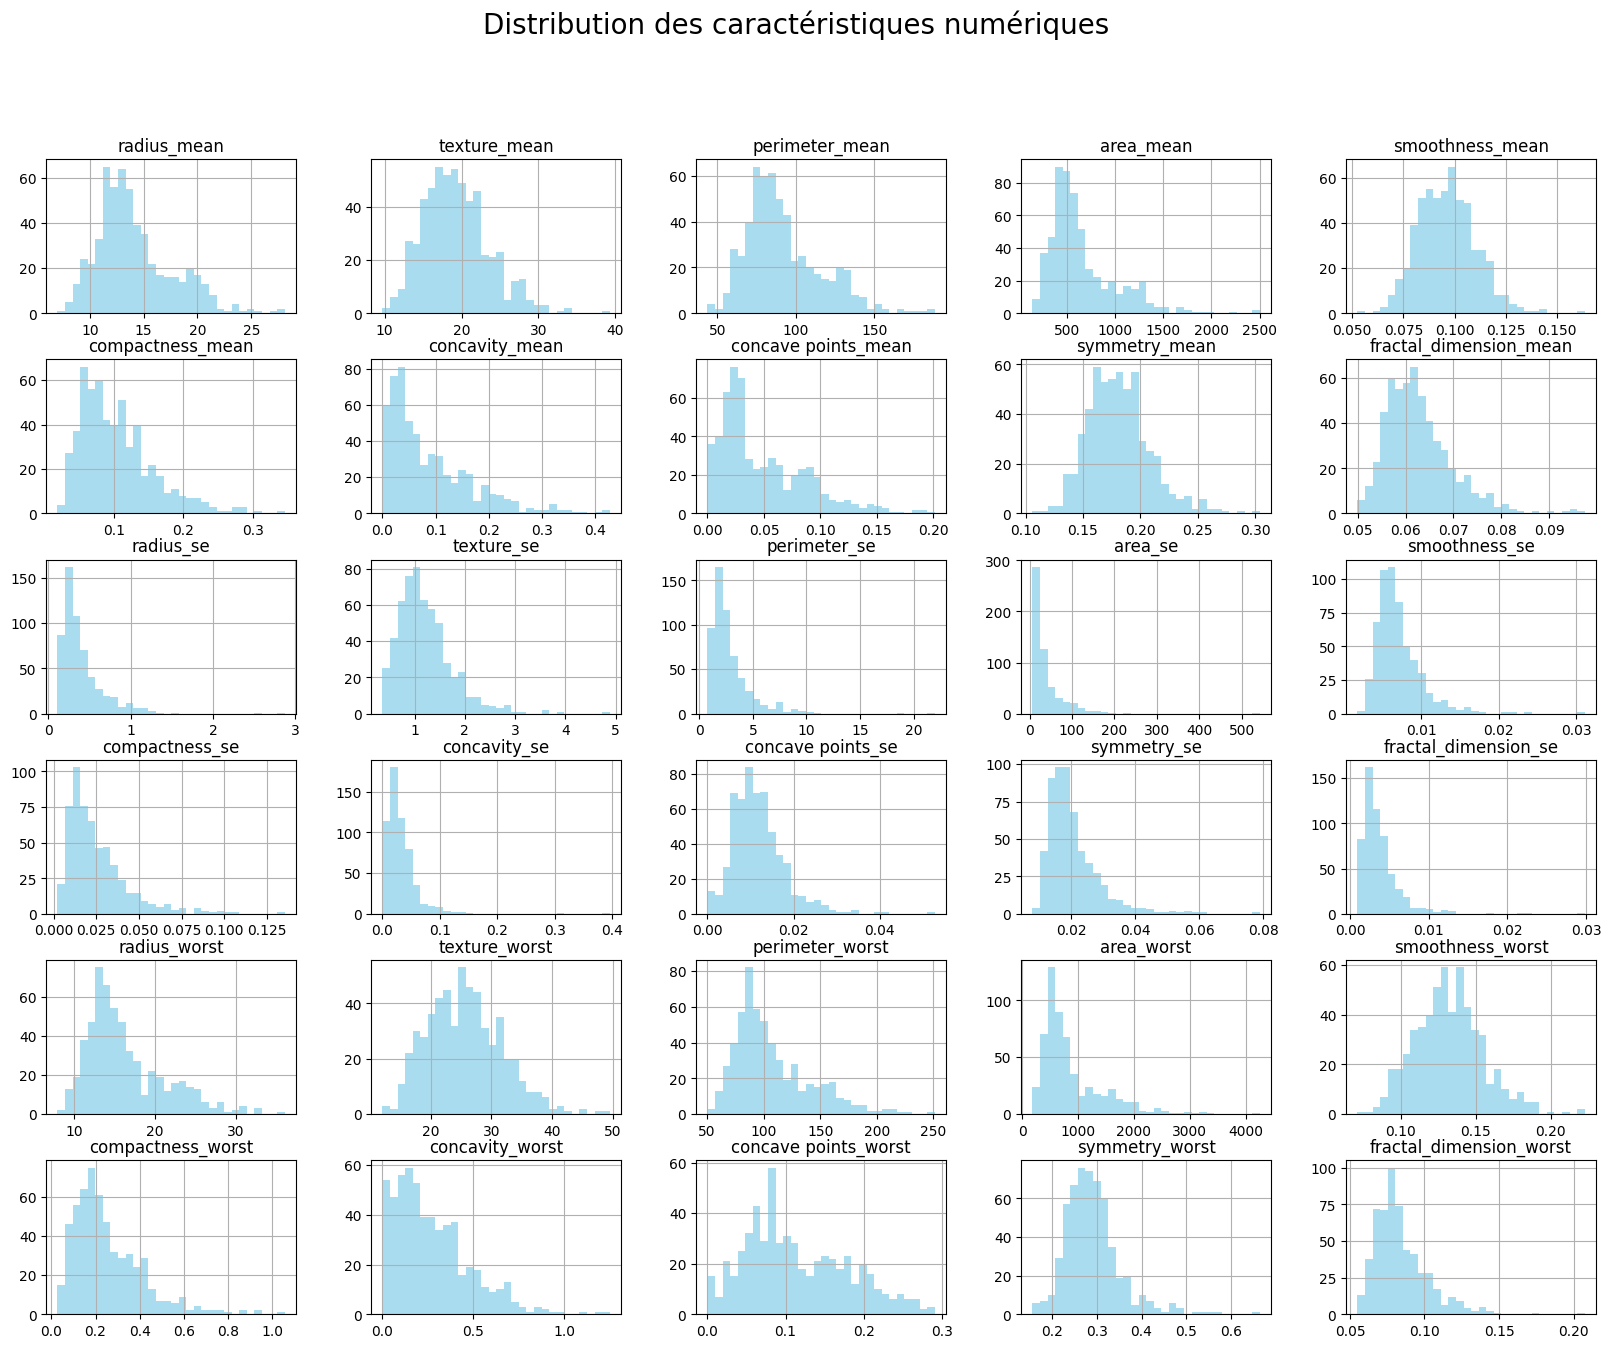

In [41]:
# Analyse univariée: Distribution des caractéristiques numériques
data_cleaned.drop(columns=["diagnosis"]).hist(bins=30, figsize=(20, 15), color='skyblue', alpha=0.7)
plt.suptitle('Distribution des caractéristiques numériques', fontsize=20)
plt.show()


### Analyse bivariée

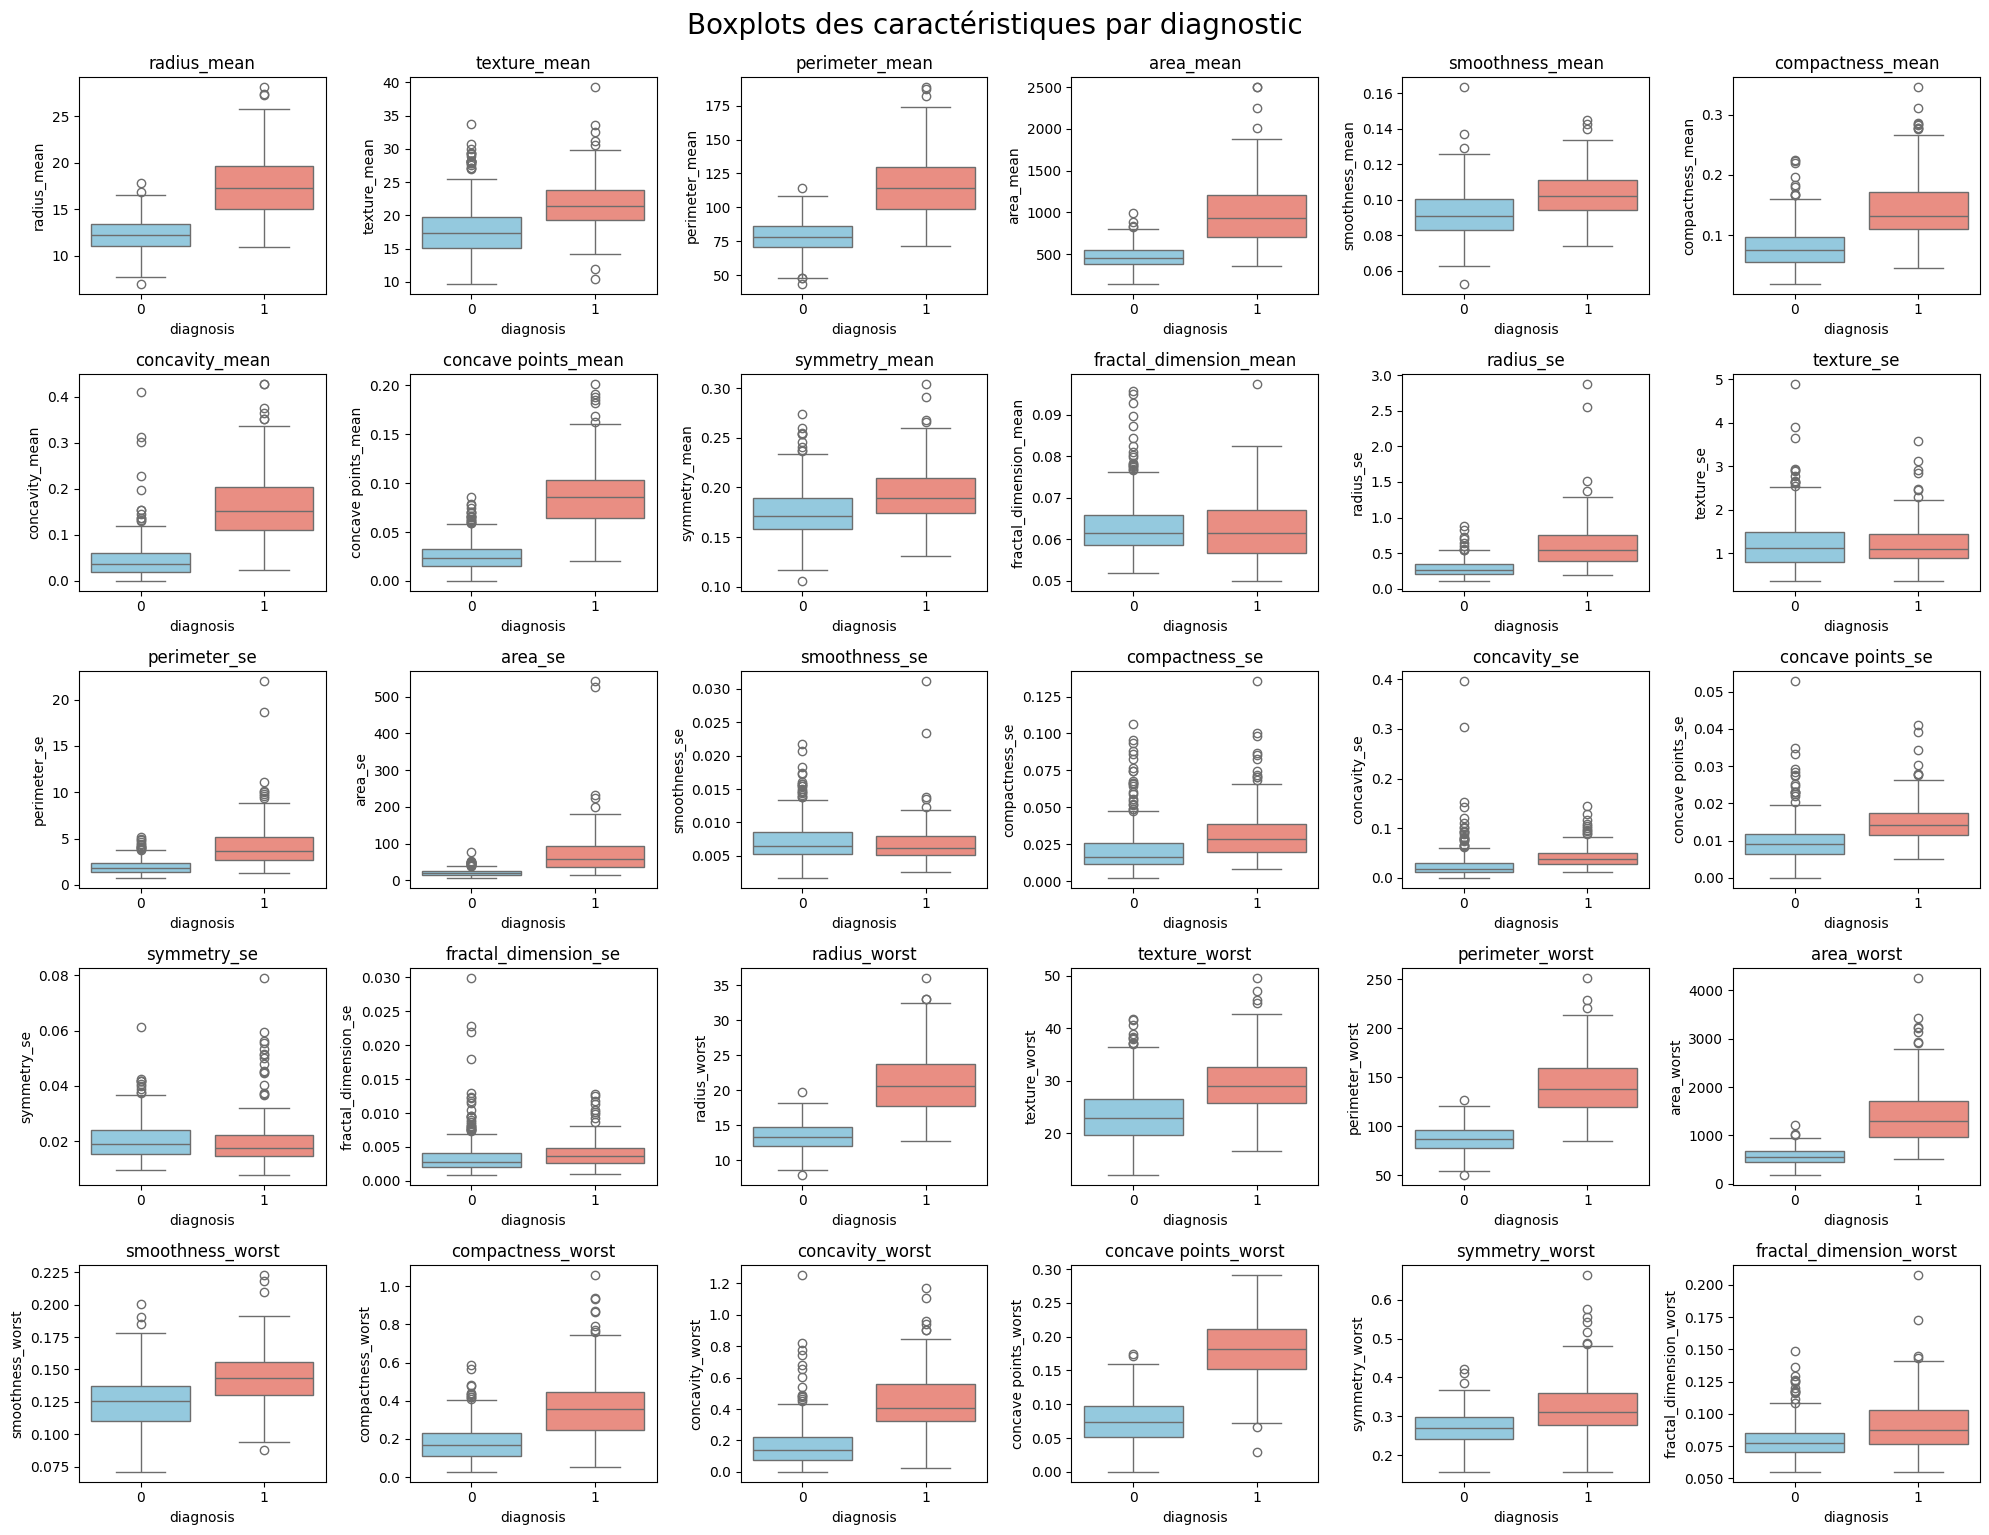

In [42]:
# Analyse bivariée: Boxplots pour visualiser la distribution des caractéristiques par diagnostic
plt.figure(figsize=(20, 15))
for i, column in enumerate(data_cleaned.columns[1:], 1):
    plt.subplot(5, 6, i)
    sns.boxplot(x='diagnosis', y=column, data=data_cleaned, palette=['skyblue', 'salmon'])
    plt.title(column)
    plt.tight_layout()
plt.suptitle('Boxplots des caractéristiques par diagnostic', fontsize=20, y=1.02)
plt.show()

# Ignorer les warnings
warnings.filterwarnings('ignore')



### Analyse multivariée

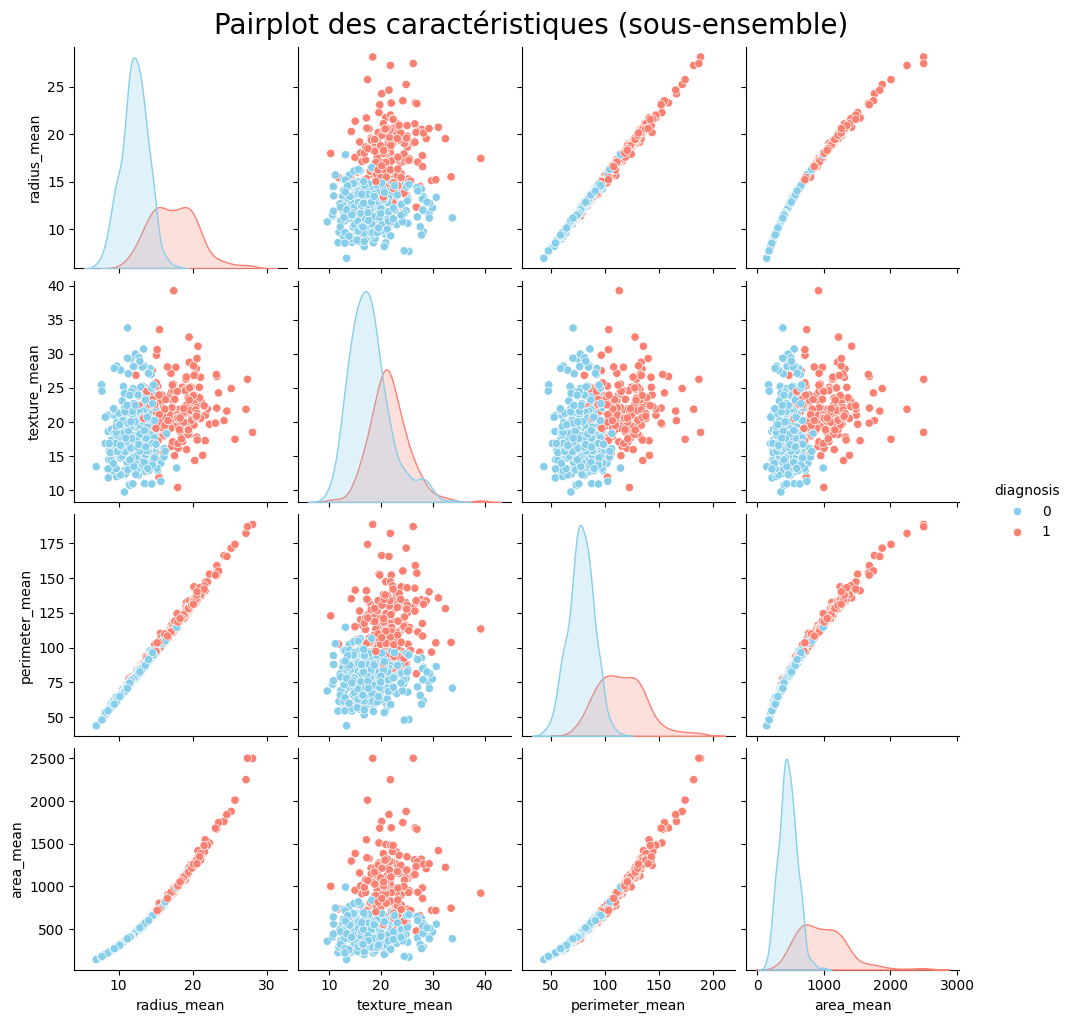

In [43]:
# Analyse multivariée: Pairplot pour visualiser les relations entre les caractéristiques
sns.pairplot(data_cleaned, vars=data_cleaned.columns[1:5], hue='diagnosis', palette=['skyblue', 'salmon'], diag_kind='kde')
plt.suptitle('Pairplot des caractéristiques (sous-ensemble)', fontsize=20, y=1.02)
plt.show()

# Réduction des dimensions

Avant de procéder à la réduction des dimensions nous allons normaliser les caractéristiques de notre dataset

In [44]:
# Normalisation des caractéristiques
scaler = StandardScaler()
features = data_cleaned.drop(columns=["diagnosis"])
features_scaled = scaler.fit_transform(features)

Pour la réduction des dimensions nous avons décidé d'utiliser la méthode PCA

In [45]:
# Application de PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

In [46]:
# Création d'un DataFrame avec les composantes principales
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [47]:
# Ajout de la variable cible pour visualisation
principal_df = pd.concat([principal_df, data_cleaned['diagnosis']], axis=1)

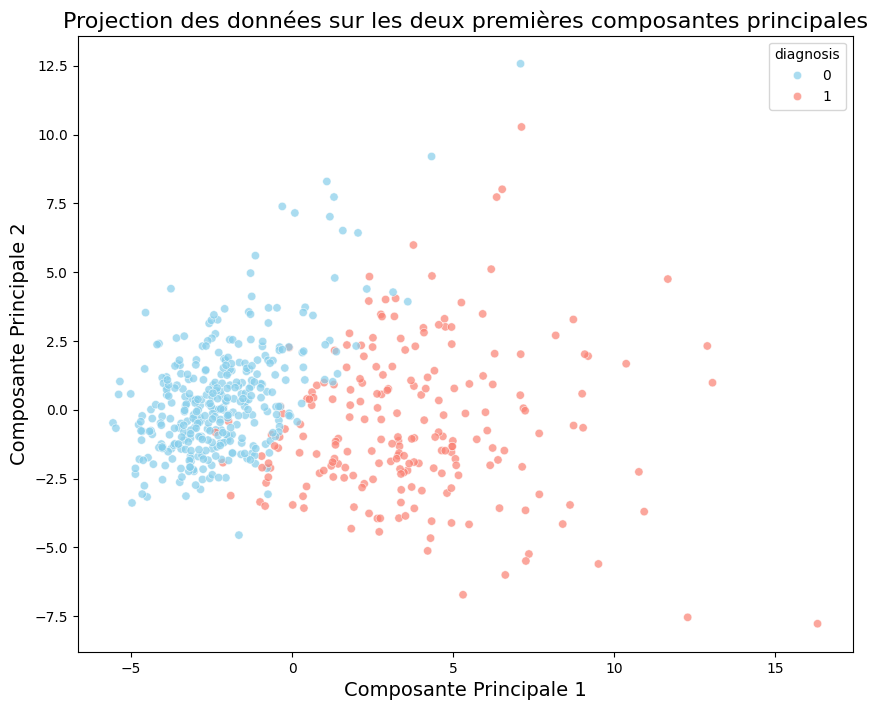

In [48]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='diagnosis', data=principal_df, palette=['skyblue', 'salmon'], alpha=0.7)
plt.title('Projection des données sur les deux premières composantes principales', fontsize=16)
plt.xlabel('Composante Principale 1', fontsize=14)
plt.ylabel('Composante Principale 2', fontsize=14)
plt.show()

In [49]:
# Explication des composantes
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par la première composante: {explained_variance[0]:.2f}")
print(f"Variance expliquée par la deuxième composante: {explained_variance[1]:.2f}")

Variance expliquée par la première composante: 0.44
Variance expliquée par la deuxième composante: 0.19


## Test du dataset avec un modèle de regression logistique

In [50]:
# Modélisation: Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(principal_df[['PC1', 'PC2']], data_cleaned['diagnosis'], test_size=0.2, stratify=data_cleaned['diagnosis'])

In [51]:
# Entraînement d'un modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [52]:
# Prédictions
y_pred = model.predict(X_test)

In [53]:
# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:
 [[71  1]
 [ 1 41]]


# Modélisation avec notre Perceptron

Import du modèle de Perceptron

In [54]:
from main import Perceptron

Training complete after 1000 epochs
Accuracy: 94.38%


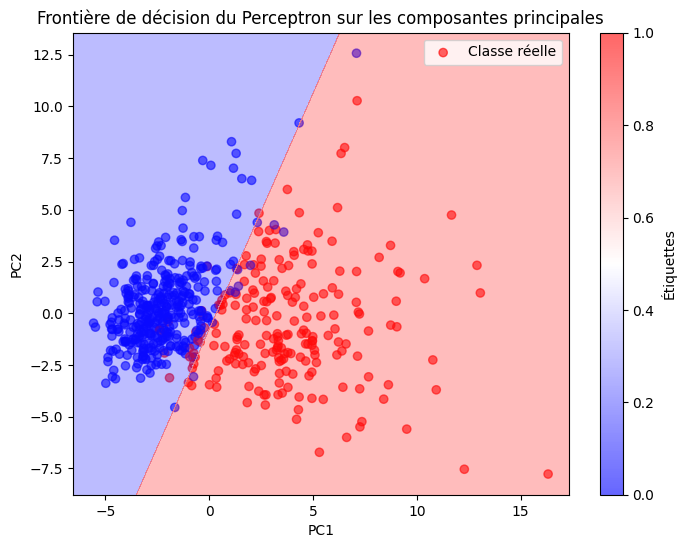

In [58]:
y = data_cleaned['diagnosis'].values

# Ajouter les étiquettes au DataFrame des composantes principales
principal_df['label'] = y

# Séparer les caractéristiques (X) et les étiquettes (y)
X = principal_df[['PC1', 'PC2']].values  # Caractéristiques (composantes principales)
y = principal_df['label'].values         # Étiquettes

# Instancier et entraîner le perceptron
perceptron = Perceptron(input_dim=X.shape[1], learning_rate=0.1, epochs=1000)
perceptron.fit(X, y)

# Faire des prédictions
predictions = perceptron.predict(X)

# Évaluer le modèle
accuracy = np.mean(predictions == y)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", label="Classe réelle", alpha=0.6)
plt.colorbar(label="Étiquettes")
plt.title("Frontière de décision du Perceptron sur les composantes principales")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Tracer la frontière de décision
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
Z = perceptron.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.3, cmap="bwr")

plt.legend()
plt.show()

In [56]:
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       357
           1       0.95      0.89      0.92       212

    accuracy                           0.94       569
   macro avg       0.94      0.93      0.94       569
weighted avg       0.94      0.94      0.94       569



On observe dans le rapport de classification que nos résultats sont relativement élevés ce qui signifie que le Perceptron fonctionne bien pour ce dataset

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
perceptron.fit(X_train, y_train)
predictions = perceptron.predict(X_test)
print(f"Test Accuracy: {np.mean(predictions == y_test) * 100:.2f}%")

Training complete after 1000 epochs
Test Accuracy: 97.37%


En utilisant la méthode de train_test_split de sklearn nous remarquons que notre accuracy augmente

# Conclusion & Recommendations